<a href="https://colab.research.google.com/github/Srujanx/NHL_logo_prediction/blob/main/TML_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2

In [96]:
base_dir = '/content'
aug_dir = '/content/aug_logos'

In [97]:
teams = ['maple_leaves' , 'bruins' , 'penguins' , 'canadiens' , 'blackhawks']

In [98]:
os.makedirs(aug_dir , exist_ok = True)
for i in teams:
  os.makedirs(os.path.join(aug_dir , i) , exist_ok = True)



In [99]:
data_aug = ImageDataGenerator(rotation_range= 30 , width_shift_range= 0.2 ,
                              height_shift_range = 0.2 , shear_range = 15 , zoom_range = 0.2,
                              horizontal_flip = True , brightness_range = [0.7 , 1.3] ,
                              fill_mode = 'nearest'

)

In [100]:
original = 0
augmented = 0

for i in teams:
  team_dir = os.path.join(base_dir , i)
  aug_team_dir = os.path.join(aug_dir , i)

  images = [f for f in os.listdir(team_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
  original = original + len(images)

  for j,k in enumerate(images):
    img_path = os.path.join(team_dir , k)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    img = cv2.resize(img , (128 , 128))
    cv2.imwrite(os.path.join(aug_team_dir , f'{i}_orig_{j:03d}.jpg'),
                    cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    img_array = img.reshape((1,) + img.shape)
    l = 0
    for b in data_aug.flow(img_array , batch_size = 1):
      aug_img = b[0].astype('uint8')
      cv2.imwrite(os.path.join(aug_team_dir, f'{i}_aug_{j:03d}_{l:02d}.jpg'),
                       cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))
      l = l + 1
      if l >= 15:
        break
  team_total = len(os.listdir(aug_team_dir))
  augmented = augmented + team_total



In [101]:
original

165

In [102]:
augmented

2640

In [103]:
augmented/original

16.0

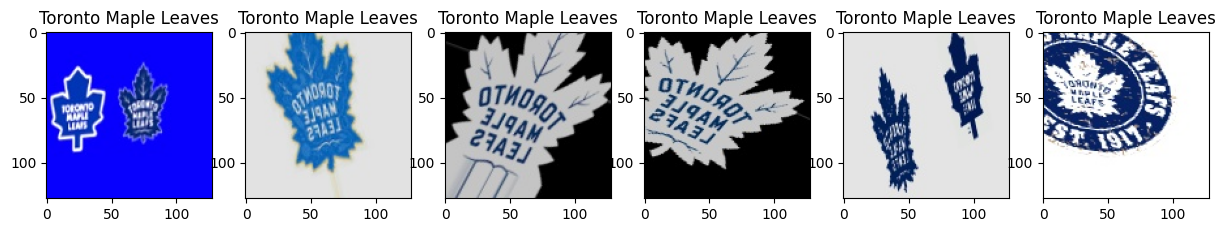

In [104]:
import matplotlib.pyplot as plt
team = 'maple_leaves'
samples = 6

aug_team_dir = os.path.join(aug_dir , team)
images = os.listdir(aug_team_dir)[:samples]
fig, axes = plt.subplots(1, samples, figsize=(15, 3))

for m, n in enumerate(images):
    img_path = os.path.join(aug_team_dir, n)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[m].imshow(img)
    axes[m].set_title('Toronto Maple Leaves')

plt.show()

In [105]:
data_aug = ImageDataGenerator(rescale = 1/255 , validation_split = 0.2)

In [106]:
train_data = data_aug.flow_from_directory( aug_dir , target_size = (128,128)
, batch_size = 32 , class_mode = 'categorical' , subset = 'training' , shuffle = True)

Found 2113 images belonging to 5 classes.


In [107]:
test_data = data_aug.flow_from_directory( aug_dir , target_size = (128,128)
, batch_size = 32 , class_mode = 'categorical' , subset = 'validation' , shuffle = False)


Found 527 images belonging to 5 classes.


In [108]:
len(train_data.class_indices)

5

In [109]:
len(test_data)

17

In [110]:
test_data.samples

527

In [111]:
train_data.samples

2113

In [112]:
from tensorflow.keras.applications import VGG16

In [113]:
model = VGG16( weights = 'imagenet' , input_shape = (128 , 128 , 3) ,
              include_top = False)
model.trainable = False

In [114]:
from tensorflow.keras import models , layers
model1 = models.Sequential([
    model
])
model1.add(layers.GlobalAveragePooling2D())
model1.add(layers.Dense(256 , activation = 'relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128 , activation = 'relu'))
model1.add(layers.Dropout(0.3))
model1.add(layers.Dense(5, activation = 'softmax'))
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,879,557 (56.76 MB)

 Trainable params: 164,869 (644.02 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


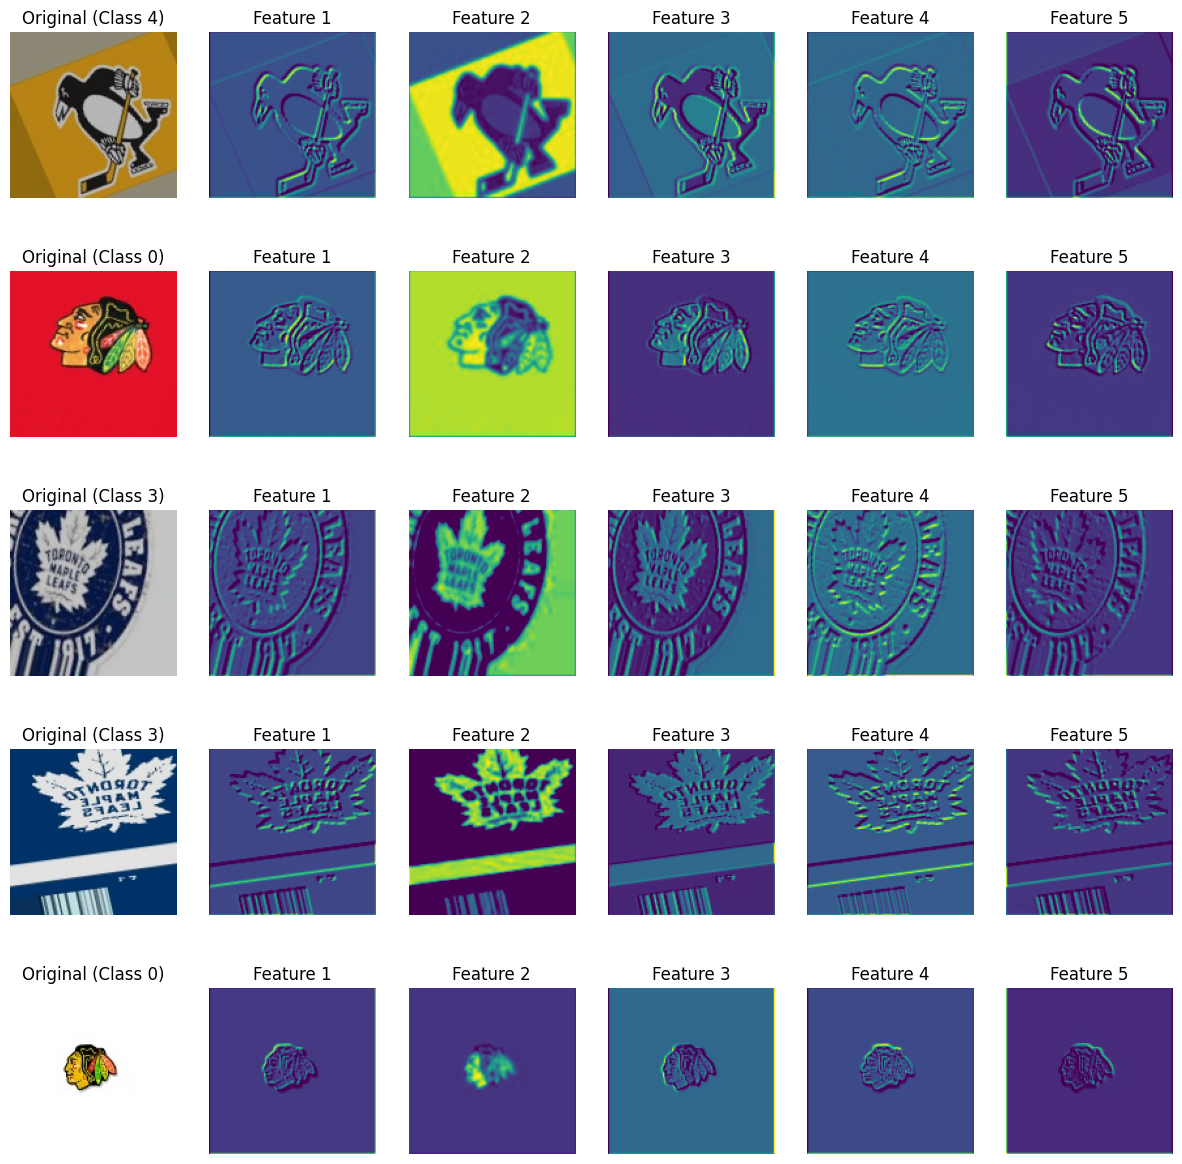

In [115]:
batch_img , batch_labels = next(train_data)
features = tf.keras.Model(inputs = model.input , outputs = model.layers[1].output)
fig, axes = plt.subplots(5, 6, figsize=(15, 3 * 5))

for i in range(min(5, len(batch_img))):
    axes[i, 0].imshow(batch_img[i])
    axes[i, 0].set_title(f'Original (Class {np.argmax(batch_labels[i])})')
    axes[i, 0].axis('off')

    # Extract feature maps
    exfeatures = features.predict(batch_img[i:i+1])

    # Show first 5 feature maps
    for j in range(5):
        axes[i, j + 1].imshow(exfeatures[0, :, :, j], cmap='viridis')
        axes[i, j + 1].set_title(f'Feature {j+1}')
        axes[i, j + 1].axis('off')
plt.show()


In [116]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint, ReduceLROnPlateau
model1.compile( optimizer = 'adam' , loss=tf.keras.losses.CategoricalCrossentropy() , metrics = ['accuracy' , 'precision' , 'recall'])

In [117]:
callbacks = [ ModelCheckpoint('/content/best_nhl_model.h5',monitor='val_accuracy',
        save_best_only=True,mode='max',verbose=False),
              EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=False
    ),

    ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,min_lr=1e-7,verbose=False )
]

In [118]:
hist = model1.fit(train_data , epochs = 5 , validation_data = test_data , callbacks = callbacks , verbose =0)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


In [119]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [120]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision', 'recall', 'val_accuracy', 'val_loss', 'val_precision', 'val_recall', 'learning_rate'])

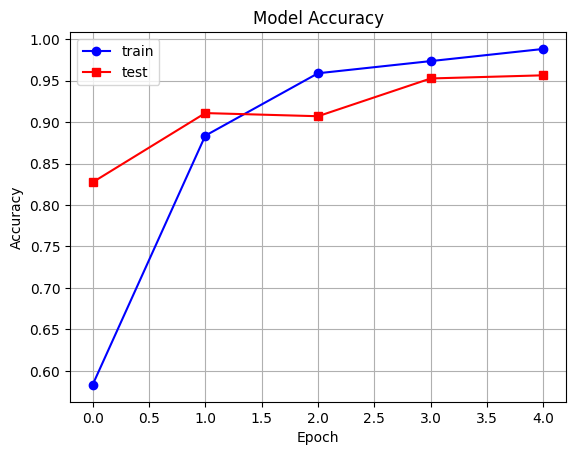

In [121]:
plt.plot(hist.history['accuracy'] , 'o-' , label = 'train' , c = 'b')
plt.plot(hist.history['val_accuracy'] , 's-' , label = 'test' , c = 'r')
plt.grid()
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

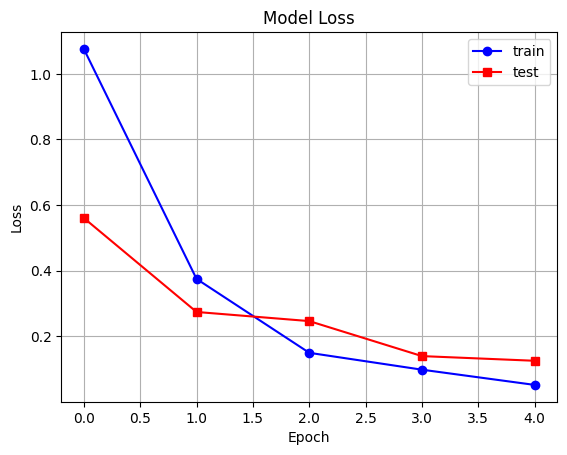

In [122]:
plt.plot(hist.history['loss'] , 'o-' , label = 'train' , c = 'b')
plt.plot(hist.history['val_loss'] , 's-' , label = 'test' , c = 'r')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()


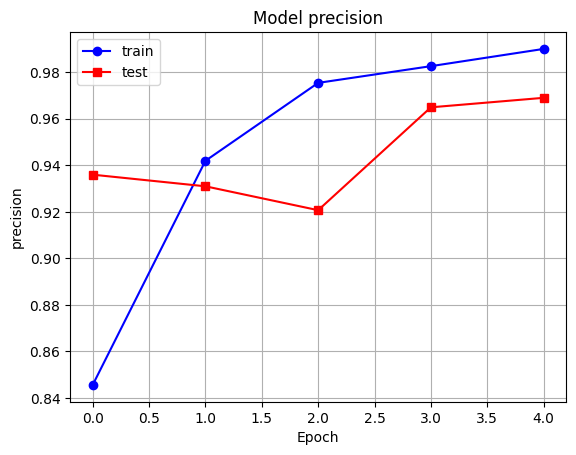

In [123]:
plt.plot(hist.history['precision'] , 'o-' , label = 'train' , c = 'b')
plt.plot(hist.history['val_precision'] , 's-' , label = 'test' , c = 'r')
plt.title('Model precision')
plt.xlabel('Epoch')
plt.ylabel('precision')
plt.legend()
plt.grid()


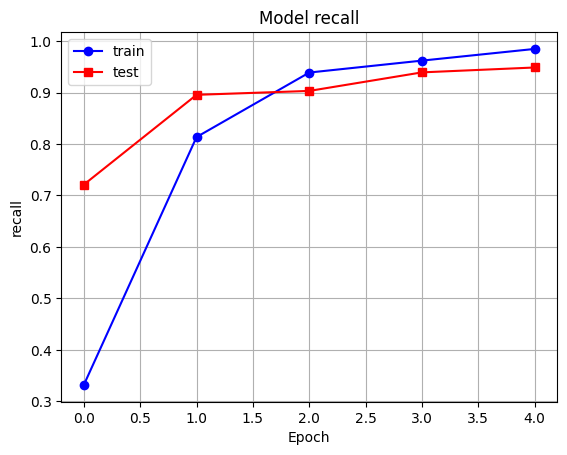

In [124]:
plt.plot(hist.history['recall'] , 'o-' , label = 'train' , c = 'b')
plt.plot(hist.history['val_recall'] , 's-' , label = 'test' , c = 'r')
plt.title('Model recall')
plt.xlabel('Epoch')
plt.ylabel('recall')
plt.legend()
plt.grid()

In [125]:
for key in hist.history.keys():
        hist.history[key].extend(hist2.history[key])

In [126]:
evaluation_results = model1.evaluate(test_data, verbose=0)
val_loss = evaluation_results[0]
val_acc = evaluation_results[1]

In [127]:
val_acc

0.9563567638397217

In [128]:
val_loss

0.1252651810646057

In [129]:
test_data.reset()
predictions = model1.predict(test_data)
y_pred = np.argmax(predictions, axis=1)
y_true = test_data.classes

17/17 ━━━━━━━━━━━━━━━━━━━━ 91s 5s/step


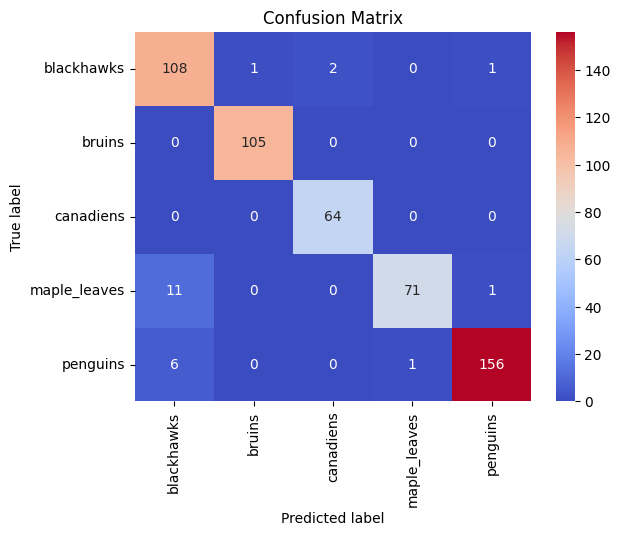

In [130]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=list(train_data.class_indices.keys()),
            yticklabels=list(train_data.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [131]:
cr = classification_report(y_true, y_pred, target_names=list(train_data.class_indices.keys()))
print(cr)

              precision    recall  f1-score   support

  blackhawks       0.86      0.96      0.91       112
      bruins       0.99      1.00      1.00       105
   canadiens       0.97      1.00      0.98        64
maple_leaves       0.99      0.86      0.92        83
    penguins       0.99      0.96      0.97       163

    accuracy                           0.96       527
   macro avg       0.96      0.96      0.96       527
weighted avg       0.96      0.96      0.96       527




Random Sample Predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


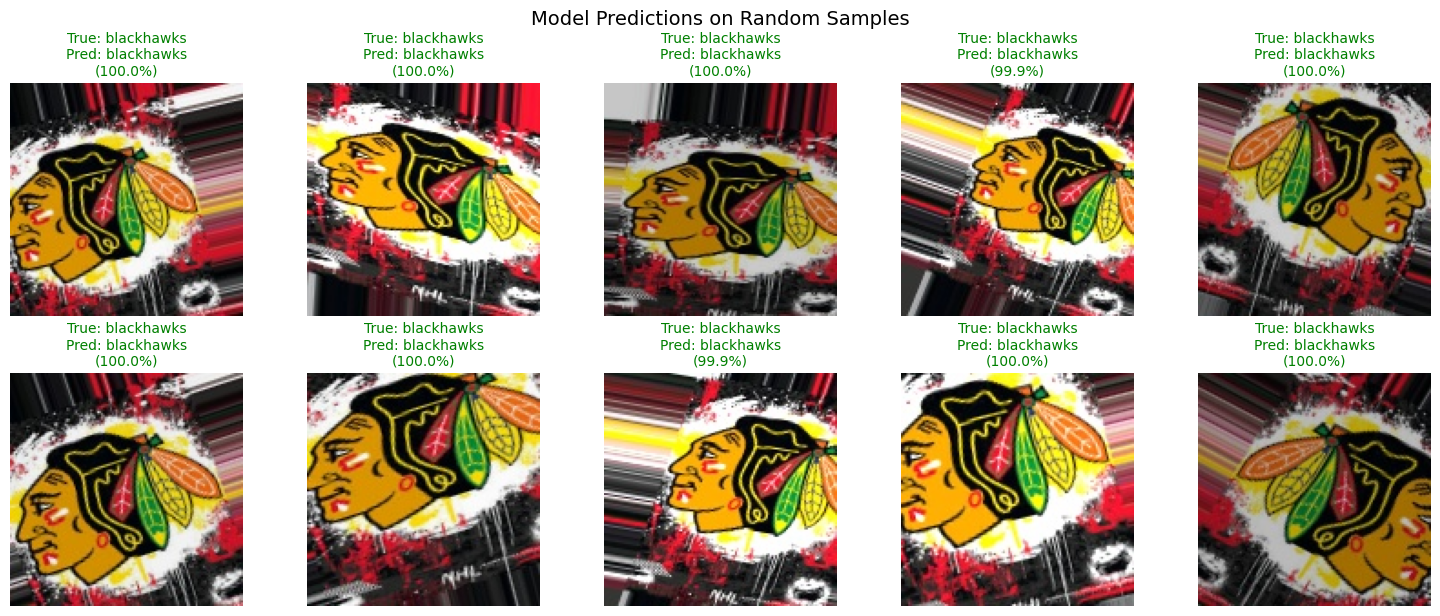


✓ Model saved as 'final_nhl_classifier.h5'

Model Information:
  Total parameters: 14,879,557
  Trainable parameters: 164,869
  Non-trainable parameters: 14,714,688

Testing on another batch of samples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


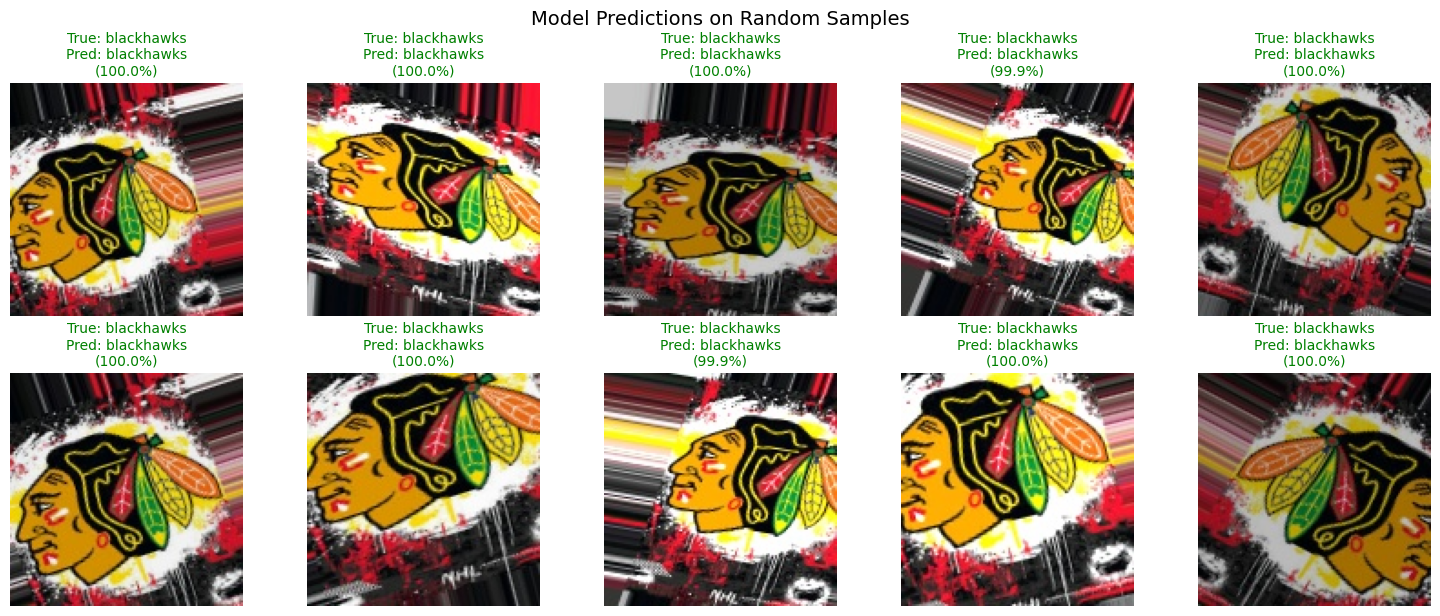


Model Confidence Analysis:
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


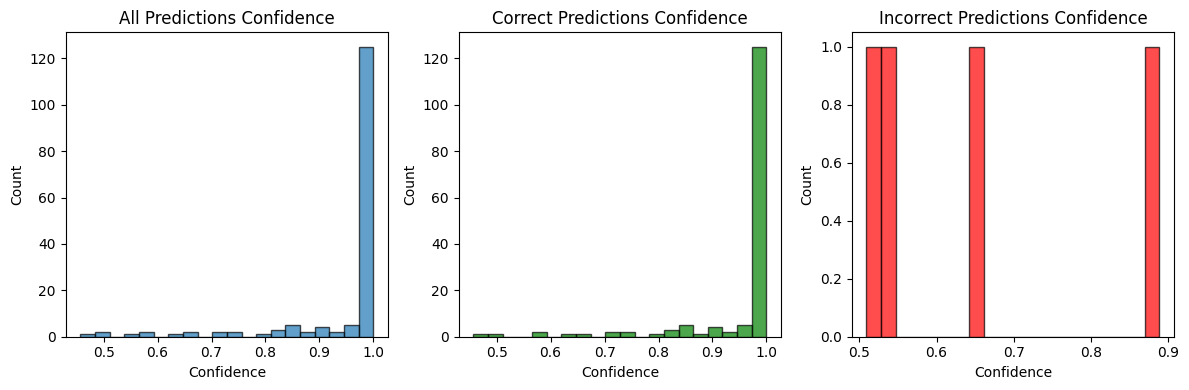

Average confidence - Correct: 0.960
Average confidence - Incorrect: 0.649


In [132]:
# Test on random samples
def test_random_samples(model, generator, num_samples=10):
    batch_images, batch_labels = next(generator)
    predictions = model.predict(batch_images[:num_samples])

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()

    class_names = list(generator.class_indices.keys())

    for i in range(min(num_samples, len(batch_images))):
        img = batch_images[i]
        true_label = class_names[np.argmax(batch_labels[i])]
        pred_label = class_names[np.argmax(predictions[i])]
        confidence = np.max(predictions[i]) * 100

        axes[i].imshow(img)
        color = 'green' if true_label == pred_label else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)',
                         color=color, fontsize=10)
        axes[i].axis('off')

    # Hide any unused subplots
    for j in range(i+1, 10):
        axes[j].axis('off')

    plt.tight_layout()
    plt.suptitle('Model Predictions on Random Samples', y=1.02, fontsize=14)
    plt.show()

print("\nRandom Sample Predictions:")
test_random_samples(model1, test_data)

# Save the final model - using model1 consistently
model1.save('/content/final_nhl_classifier.h5')
print("\n✓ Model saved as 'final_nhl_classifier.h5'")

# Model size and complexity - using model1 consistently
print("\n" + "="*50)
print("Model Information:")
print(f"  Total parameters: {model1.count_params():,}")
print(f"  Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model1.trainable_weights]):,}")
print(f"  Non-trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model1.non_trainable_weights]):,}")

# Additional: Test with a fresh batch to ensure variety
print("\n" + "="*50)
print("Testing on another batch of samples:")
test_data.reset()  # Reset generator
test_random_samples(model1, test_data, num_samples=10)

# Optional: Show model's confidence distribution
def plot_confidence_distribution(model, generator, num_batches=5):
    """Plot distribution of model's prediction confidence"""
    all_confidences = []
    correct_confidences = []
    incorrect_confidences = []

    for _ in range(num_batches):
        batch_images, batch_labels = next(generator)
        predictions = model.predict(batch_images)

        for i in range(len(predictions)):
            confidence = np.max(predictions[i])
            all_confidences.append(confidence)

            true_label = np.argmax(batch_labels[i])
            pred_label = np.argmax(predictions[i])

            if true_label == pred_label:
                correct_confidences.append(confidence)
            else:
                incorrect_confidences.append(confidence)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.hist(all_confidences, bins=20, edgecolor='black', alpha=0.7)
    plt.title('All Predictions Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')

    plt.subplot(1, 3, 2)
    plt.hist(correct_confidences, bins=20, color='green', edgecolor='black', alpha=0.7)
    plt.title('Correct Predictions Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')

    plt.subplot(1, 3, 3)
    plt.hist(incorrect_confidences, bins=20, color='red', edgecolor='black', alpha=0.7)
    plt.title('Incorrect Predictions Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

    print(f"Average confidence - Correct: {np.mean(correct_confidences):.3f}")
    if incorrect_confidences:
        print(f"Average confidence - Incorrect: {np.mean(incorrect_confidences):.3f}")

print("\n" + "="*50)
print("Model Confidence Analysis:")
test_data.reset()
plot_confidence_distribution(model1, test_data)

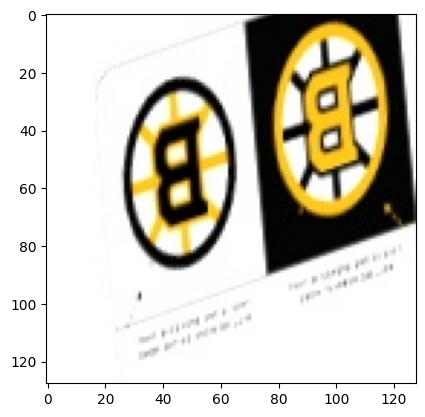

In [133]:
images, labels = next(iter(test_data))
idx = 1
plt.imshow(images[idx])
plt.show()

In [134]:
img = np.expand_dims(images[idx], axis=0)
pred = model1.predict(img)
pred_idx = np.argmax(pred)

print(f" Predicted Team: {teams[pred_idx]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
 Predicted Team: bruins
